In this notebook, I predict the rating of video games. This dataset can be treated as both continuous and categorical, so I created two models: one using the target as a continuous variable and the other as a categorical variable. For the categorical model, I had to round the target values and balance the population. The data processing sections include Data Cleaning, Feature Engineering, Time Series Creation, and Exploratory Data Analysis (EDA).

Michael Barajas

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)

# Functions

In [226]:
#This function considers outliers as values that are greater than twice the 99th percentile value 
#and values that are less than half of the 1st percentile value.
def outliers(df):
    descriptive_stats = df.describe(percentiles=[0.01, 0.99])
    higher_99 = []
    lower_01 = []
    
    # Identificar columnas con valores mayores al percentil 99 o menores al percentil 01
    for col in df.columns:
        max_val = descriptive_stats.loc['max', col]
        percentile_99 = descriptive_stats.loc['99%', col]
        min_val = descriptive_stats.loc['min', col]
        percentile_01 = descriptive_stats.loc['1%', col]
    
        if max_val > 2 * percentile_99:
            higher_99.append(col)
    
        if min_val < percentile_01 / 2:
            lower_01.append(col)
    
    print("Variables cuyo máximo es mayor al doble del percentil 99:", higher_99)
    print("Variables cuyo mínimo es menor a la mitad del percentil 01:", lower_01)
    
    # Filtrar filas con valores atípicos
    for col in higher_99:
        threshold = descriptive_stats.loc['99%', col]
        df = df[df[col] <= threshold]
    
    for col in lower_01:
        threshold = descriptive_stats.loc['1%', col]
        df = df[df[col] >= threshold]
    
    return df

In [227]:
#This function trains multiple models and tests them using cross-validation, then displays the R² scores of all models to compare which is best. 
#It also allows for the use of models with hyperparameters. The models used are: Linear Regression, LARS, Ridge, Lasso, Elastic Net, and Bayesian Ridge.
def getScores(X, y, hype=False):
    dc_scores = dict()
    
    if hype:
        param_grids = {
            'LinearRegression': {},
            'Lars': {},
            'Ridge': {'alpha': np.arange(0, 1001, 10)},
            'Lasso': {'alpha': np.arange(0, 1001, 10)},
            'ElasticNet': {'alpha': np.arange(0.1, 1, 0.1), 'l1_ratio': np.arange(0, 1, 0.01)},
            'BayesianRidge': {}
        }
        models = {
            'LinearRegression': LinearRegression(),
            'Lars': Lars(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'ElasticNet': ElasticNet(),
            'BayesianRidge': BayesianRidge()
        }

        # Perform GridSearchCV for each model
        for name, model in models.items():
            if param_grids[name]:
                grid_search = GridSearchCV(model, param_grids[name], cv=4, scoring='r2', n_jobs=-1)
                grid_search.fit(X, y)
                best_model = grid_search.best_estimator_
                best_params = grid_search.best_params_
                print(f"Best parameters for {name}: {best_params}")
                ls_res = cross_val_score(estimator=best_model, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
            else:
                model.fit(X, y)
                ls_res = cross_val_score(estimator=model, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
            dc_scores.update({name: np.mean(ls_res)})
    else:
        linreg = LinearRegression(fit_intercept=True)
        linreg.fit(X, y)
        ls_res = cross_val_score(estimator=linreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(linreg).split("(")[0]: np.mean(ls_res)})

        larsreg = Lars()
        larsreg = larsreg.fit(X, y)
        ls_res = cross_val_score(estimator=larsreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(larsreg).split("(")[0]: np.mean(ls_res)})

        ridgereg = Ridge()
        ridgereg.fit(X, y)
        ls_res = cross_val_score(estimator=ridgereg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(ridgereg).split("(")[0]: np.mean(ls_res)})

        lassreg = Lasso()
        lassreg.fit(X, y)
        ls_res = cross_val_score(estimator=lassreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(lassreg).split("(")[0]: np.mean(ls_res)})

        elasnet = ElasticNet(alpha=0.5, l1_ratio=0.99)
        elasnet.fit(X, y)
        ls_res = cross_val_score(estimator=elasnet, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(elasnet).split("(")[0]: np.mean(ls_res)})

        bayreg = BayesianRidge()
        bayreg.fit(X, y)
        ls_res = cross_val_score(estimator=bayreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")
        dc_scores.update({str(bayreg).split("(")[0]: np.mean(ls_res)})

    return dc_scores

# Data

In [228]:
df = pd.read_csv('game_info.csv')

In [229]:
df.head()

,id,slug,name,metacritic,released,tba,updated,website,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,platforms,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing
0,1,dgeneration-hd,D/Generation HD,NaN,2015-10-23,False,2019-09-17T11:58:57,http://dgeneration.net,0.0,0,1,80,2,292,0,4,PC||macOS||Xbox One||PlayStation 4||Nintendo S...,West Coast Software,Adventure||Puzzle,West Coast Software,Everyone 10+,4,88,2,2,0,0
1,10,g-prime,G Prime Into The Rain,NaN,2016-01-06,False,2019-11-06T23:04:19,NaN,0.0,0,0,26,3,389,0,3,macOS||PC||Xbox One,Soma Games,Simulation||Indie,Immanitas Entertainment||Code-Monkeys,Everyone,2,42,2,0,0,0
2,100,land-sliders,Land Sliders,NaN,2015-09-24,False,2019-10-22T13:56:16,http://prettygreat.com,0.0,0,0,0,2,83,0,2,iOS,Prettygreat Pty,Adventure||Arcade,Prettygreat Pty,Everyone 10+,0,2,2,0,1,0
3,1000,pixel-gear,Pixel Gear,NaN,2016-10-20,False,2019-08-28T22:16:02,https://www.facebook.com/Geronimo-Interactive-...,0.0,0,0,0,0,455,0,0,PC||PlayStation 4,Oasis Games||Geronimo Interactive,Action||Indie,Geronimo Interactive,Teen,0,1,0,0,0,0
4,10000,gods-and-idols,Gods and Idols,NaN,2016-12-12,False,2019-09-17T13:37:13,http://www.godsandidols.com/,0.0,1,1,0,5,262,0,5,PC,Viking Tao,RPG||Strategy||Massively Multiplayer,Viking Tao,NaN,2,79,0,0,0,0


# Feature Engineering

We begin by decomposing the 'platforms' variable into multiple variables, one for each possible value

In [230]:
platform_counts = {}

total_non_null = df['platforms'].dropna().shape[0]

for platforms in df['platforms'].dropna():
    for platform in platforms.split('||'):
        platform = platform.strip()
        if platform in platform_counts:
            platform_counts[platform] += 1
        else:
            platform_counts[platform] = 1

platform_list = sorted(platform_counts.items())

for platform, count in platform_list:
    percentage = (count / total_non_null) * 100
    print(f"{platform}: {percentage:.2f}%")

3DO: 0.02%
Android: 7.06%
Apple II: 0.09%
Atari 2600: 0.06%
Atari 5200: 0.01%
Atari 7800: 0.01%
Atari 8-bit: 0.06%
Atari Flashback: 0.01%
Atari Lynx: 0.01%
Atari ST: 0.17%
Atari XEGS: 0.00%
Classic Macintosh: 0.13%
Commodore / Amiga: 0.43%
Dreamcast: 0.07%
Game Boy: 0.12%
Game Boy Advance: 0.19%
Game Boy Color: 0.08%
Game Gear: 0.03%
GameCube: 0.13%
Genesis: 0.17%
Jaguar: 0.01%
Linux: 9.10%
NES: 0.19%
Neo Geo: 0.02%
Nintendo 3DS: 0.37%
Nintendo 64: 0.08%
Nintendo DS: 0.49%
Nintendo DSi: 0.01%
Nintendo Switch: 0.84%
PC: 58.76%
PS Vita: 0.41%
PSP: 0.33%
PlayStation: 0.32%
PlayStation 2: 0.39%
PlayStation 3: 0.77%
PlayStation 4: 1.15%
PlayStation 5: 0.02%
SEGA 32X: 0.01%
SEGA CD: 0.03%
SEGA Master System: 0.04%
SEGA Saturn: 0.06%
SNES: 0.18%
Web: 23.73%
Wii: 0.50%
Wii U: 0.27%
Xbox: 0.14%
Xbox 360: 0.57%
Xbox One: 0.87%
Xbox Series S/X: 0.02%
iOS: 14.36%
macOS: 13.11%


In [231]:
unique_platforms = set()

for platforms in df['platforms'].dropna():
    for platform in platforms.split('||'):
        unique_platforms.add(platform.strip())

unique_platforms_list = sorted(list(unique_platforms))

for platform in unique_platforms_list:
    df[platform] = 0

for idx, platforms in df['platforms'].dropna().items():
    for platform in platforms.split('||'):
        platform = platform.strip()
        df.at[idx, platform] = 1

df.head()

,id,slug,name,metacritic,released,tba,updated,website,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,platforms,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing,3DO,Android,Apple II,Atari 2600,Atari 5200,Atari 7800,Atari 8-bit,Atari Flashback,Atari Lynx,Atari ST,Atari XEGS,Classic Macintosh,Commodore / Amiga,Dreamcast,Game Boy,Game Boy Advance,Game Boy Color,Game Gear,GameCube,Genesis,Jaguar,Linux,NES,Neo Geo,Nintendo 3DS,Nintendo 64,Nintendo DS,Nintendo DSi,Nintendo Switch,PC,PS Vita,PSP,PlayStation,PlayStation 2,PlayStation 3,PlayStation 4,PlayStation 5,SEGA 32X,SEGA CD,SEGA Master System,SEGA Saturn,SNES,Web,Wii,Wii U,Xbox,Xbox 360,Xbox One,Xbox Series S/X,iOS,macOS
0,1,dgeneration-hd,D/Generation HD,NaN,2015-10-23,False,2019-09-17T11:58:57,http://dgeneration.net,0.0,0,1,80,2,292,0,4,PC||macOS||Xbox One||PlayStation 4||Nintendo S...,West Coast Software,Adventure||Puzzle,West Coast Software,Everyone 10+,4,88,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,10,g-prime,G Prime Into The Rain,NaN,2016-01-06,False,2019-11-06T23:04:19,NaN,0.0,0,0,26,3,389,0,3,macOS||PC||Xbox One,Soma Games,Simulation||Indie,Immanitas Entertainment||Code-Monkeys,Everyone,2,42,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,100,land-sliders,Land Sliders,NaN,2015-09-24,False,2019-10-22T13:56:16,http://prettygreat.com,0.0,0,0,0,2,83,0,2,iOS,Prettygreat Pty,Adventure||Arcade,Prettygreat Pty,Everyone 10+,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1000,pixel-gear,Pixel Gear,NaN,2016-10-20,False,2019-08-28T22:16:02,https://www.facebook.com/Geronimo-Interactive-...,0.0,0,0,0,0,455,0,0,PC||PlayStation 4,Oasis Games||Geronimo Interactive,Action||Indie,Geronimo Interactive,Teen,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10000,gods-and-idols,Gods and Idols,NaN,2016-12-12,False,2019-09-17T13:37:13,http://www.godsandidols.com/,0.0,1,1,0,5,262,0,5,PC,Viking Tao,RPG||Strategy||Massively Multiplayer,Viking Tao,NaN,2,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [232]:
df.columns

Index(['id', 'slug', 'name', 'metacritic', 'released', 'tba', 'updated',
       'website', 'rating', 'rating_top', 'playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'platforms', 'developers', 'genres', 'publishers',
       'esrb_rating', 'added_status_yet', 'added_status_owned',
       'added_status_beaten', 'added_status_toplay', 'added_status_dropped',
       'added_status_playing', '3DO', 'Android', 'Apple II', 'Atari 2600',
       'Atari 5200', 'Atari 7800', 'Atari 8-bit', 'Atari Flashback',
       'Atari Lynx', 'Atari ST', 'Atari XEGS', 'Classic Macintosh',
       'Commodore / Amiga', 'Dreamcast', 'Game Boy', 'Game Boy Advance',
       'Game Boy Color', 'Game Gear', 'GameCube', 'Genesis', 'Jaguar', 'Linux',
       'NES', 'Neo Geo', 'Nintendo 3DS', 'Nintendo 64', 'Nintendo DS',
       'Nintendo DSi', 'Nintendo Switch', 'PC', 'PS Vita', 'PSP',
       'PlayStation', 'PlayStation 2', 'PlayStation 3', 'PlayStatio

In [233]:
new_columns = ['3DO', 'Android', 'Apple II', 'Atari 2600',
       'Atari 5200', 'Atari 7800', 'Atari 8-bit', 'Atari Flashback',
       'Atari Lynx', 'Atari ST', 'Atari XEGS', 'Classic Macintosh',
       'Commodore / Amiga', 'Dreamcast', 'Game Boy', 'Game Boy Advance',
       'Game Boy Color', 'Game Gear', 'GameCube', 'Genesis', 'Jaguar', 'Linux',
       'NES', 'Neo Geo', 'Nintendo 3DS', 'Nintendo 64', 'Nintendo DS',
       'Nintendo DSi', 'Nintendo Switch', 'PC', 'PS Vita', 'PSP',
       'PlayStation', 'PlayStation 2', 'PlayStation 3', 'PlayStation 4',
       'PlayStation 5', 'SEGA 32X', 'SEGA CD', 'SEGA Master System',
       'SEGA Saturn', 'SNES', 'Web', 'Wii', 'Wii U', 'Xbox', 'Xbox 360',
       'Xbox One', 'Xbox Series S/X', 'iOS', 'macOS']

In [234]:
cols_to_combine = [col for col in new_columns if (df[col] == 0).mean() >= 0.95]

df['Other_platforms'] = df[cols_to_combine].any(axis=1).astype(int)

df.drop(columns=cols_to_combine, inplace=True)
df.drop(columns=['platforms'], inplace=True)

print("Columns combined into 'Other_platforms':", cols_to_combine)

Columns combined into 'Other_platforms': ['3DO', 'Apple II', 'Atari 2600', 'Atari 5200', 'Atari 7800', 'Atari 8-bit', 'Atari Flashback', 'Atari Lynx', 'Atari ST', 'Atari XEGS', 'Classic Macintosh', 'Commodore / Amiga', 'Dreamcast', 'Game Boy', 'Game Boy Advance', 'Game Boy Color', 'Game Gear', 'GameCube', 'Genesis', 'Jaguar', 'NES', 'Neo Geo', 'Nintendo 3DS', 'Nintendo 64', 'Nintendo DS', 'Nintendo DSi', 'Nintendo Switch', 'PS Vita', 'PSP', 'PlayStation', 'PlayStation 2', 'PlayStation 3', 'PlayStation 4', 'PlayStation 5', 'SEGA 32X', 'SEGA CD', 'SEGA Master System', 'SEGA Saturn', 'SNES', 'Wii', 'Wii U', 'Xbox', 'Xbox 360', 'Xbox One', 'Xbox Series S/X']


Now we do the same to the 'genres' variable

In [235]:
platform_counts = {}

total_non_null = df['genres'].dropna().shape[0]

for platforms in df['genres'].dropna():
    for platform in platforms.split('||'):
        platform = platform.strip()
        if platform in platform_counts:
            platform_counts[platform] += 1
        else:
            platform_counts[platform] = 1

platform_list = sorted(platform_counts.items())

for platform, count in platform_list:
    percentage = (count / total_non_null) * 100
    print(f"{platform}: {percentage:.2f}%")

Action: 27.48%
Adventure: 19.45%
Arcade: 5.99%
Board Games: 2.02%
Card: 1.05%
Casual: 7.64%
Educational: 2.04%
Family: 1.42%
Fighting: 1.68%
Indie: 8.93%
Massively Multiplayer: 0.62%
Platformer: 13.00%
Puzzle: 14.96%
RPG: 8.61%
Racing: 4.44%
Shooter: 8.57%
Simulation: 10.97%
Sports: 4.25%
Strategy: 8.90%


In [236]:
unique_platforms = set()

for platforms in df['genres'].dropna():
    for platform in platforms.split('||'):
        unique_platforms.add(platform.strip())

unique_platforms_list = sorted(list(unique_platforms))

for platform in unique_platforms_list:
    df[platform] = 0

for idx, platforms in df['genres'].dropna().items():
    for platform in platforms.split('||'):
        platform = platform.strip()
        df.at[idx, platform] = 1

df.head()

,id,slug,name,metacritic,released,tba,updated,website,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing,Android,Linux,PC,Web,iOS,macOS,Other_platforms,Action,Adventure,Arcade,Board Games,Card,Casual,Educational,Family,Fighting,Indie,Massively Multiplayer,Platformer,Puzzle,RPG,Racing,Shooter,Simulation,Sports,Strategy
0,1,dgeneration-hd,D/Generation HD,NaN,2015-10-23,False,2019-09-17T11:58:57,http://dgeneration.net,0.0,0,1,80,2,292,0,4,West Coast Software,Adventure||Puzzle,West Coast Software,Everyone 10+,4,88,2,2,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,10,g-prime,G Prime Into The Rain,NaN,2016-01-06,False,2019-11-06T23:04:19,NaN,0.0,0,0,26,3,389,0,3,Soma Games,Simulation||Indie,Immanitas Entertainment||Code-Monkeys,Everyone,2,42,2,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,100,land-sliders,Land Sliders,NaN,2015-09-24,False,2019-10-22T13:56:16,http://prettygreat.com,0.0,0,0,0,2,83,0,2,Prettygreat Pty,Adventure||Arcade,Prettygreat Pty,Everyone 10+,0,2,2,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000,pixel-gear,Pixel Gear,NaN,2016-10-20,False,2019-08-28T22:16:02,https://www.facebook.com/Geronimo-Interactive-...,0.0,0,0,0,0,455,0,0,Oasis Games||Geronimo Interactive,Action||Indie,Geronimo Interactive,Teen,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,10000,gods-and-idols,Gods and Idols,NaN,2016-12-12,False,2019-09-17T13:37:13,http://www.godsandidols.com/,0.0,1,1,0,5,262,0,5,Viking Tao,RPG||Strategy||Massively Multiplayer,Viking Tao,NaN,2,79,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


In [237]:
df.columns

Index(['id', 'slug', 'name', 'metacritic', 'released', 'tba', 'updated',
       'website', 'rating', 'rating_top', 'playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'developers', 'genres', 'publishers', 'esrb_rating',
       'added_status_yet', 'added_status_owned', 'added_status_beaten',
       'added_status_toplay', 'added_status_dropped', 'added_status_playing',
       'Android', 'Linux', 'PC', 'Web', 'iOS', 'macOS', 'Other_platforms',
       'Action', 'Adventure', 'Arcade', 'Board Games', 'Card', 'Casual',
       'Educational', 'Family', 'Fighting', 'Indie', 'Massively Multiplayer',
       'Platformer', 'Puzzle', 'RPG', 'Racing', 'Shooter', 'Simulation',
       'Sports', 'Strategy'],
      dtype='object')

In [238]:
new_columns = ['Action',
       'Adventure', 'Arcade', 'Board Games', 'Card', 'Casual', 'Educational',
       'Family', 'Fighting', 'Indie', 'Massively Multiplayer', 'Platformer',
       'Puzzle', 'RPG', 'Racing', 'Shooter', 'Simulation', 'Sports',
       'Strategy']

In [239]:
cols_to_combine = [col for col in new_columns if (df[col] == 0).mean() >= 0.95]

df['Other_genres'] = df[cols_to_combine].any(axis=1).astype(int)

df.drop(columns=cols_to_combine, inplace=True)
df.drop(columns=['genres'], inplace=True)

print("Columns combined into 'Others_genres':", cols_to_combine)

Columns combined into 'Others_genres': ['Arcade', 'Board Games', 'Card', 'Educational', 'Family', 'Fighting', 'Massively Multiplayer', 'Racing', 'Sports']


In [240]:
df.head()

,id,slug,name,metacritic,released,tba,updated,website,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,developers,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing,Android,Linux,PC,Web,iOS,macOS,Other_platforms,Action,Adventure,Casual,Indie,Platformer,Puzzle,RPG,Shooter,Simulation,Strategy,Other_genres
0,1,dgeneration-hd,D/Generation HD,NaN,2015-10-23,False,2019-09-17T11:58:57,http://dgeneration.net,0.0,0,1,80,2,292,0,4,West Coast Software,West Coast Software,Everyone 10+,4,88,2,2,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0
1,10,g-prime,G Prime Into The Rain,NaN,2016-01-06,False,2019-11-06T23:04:19,NaN,0.0,0,0,26,3,389,0,3,Soma Games,Immanitas Entertainment||Code-Monkeys,Everyone,2,42,2,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
2,100,land-sliders,Land Sliders,NaN,2015-09-24,False,2019-10-22T13:56:16,http://prettygreat.com,0.0,0,0,0,2,83,0,2,Prettygreat Pty,Prettygreat Pty,Everyone 10+,0,2,2,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1000,pixel-gear,Pixel Gear,NaN,2016-10-20,False,2019-08-28T22:16:02,https://www.facebook.com/Geronimo-Interactive-...,0.0,0,0,0,0,455,0,0,Oasis Games||Geronimo Interactive,Geronimo Interactive,Teen,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,10000,gods-and-idols,Gods and Idols,NaN,2016-12-12,False,2019-09-17T13:37:13,http://www.godsandidols.com/,0.0,1,1,0,5,262,0,5,Viking Tao,Viking Tao,NaN,2,79,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


# Data Cleaning

In [241]:
df.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95])

,id,metacritic,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing,Android,Linux,PC,Web,iOS,macOS,Other_platforms,Action,Adventure,Casual,Indie,Platformer,Puzzle,RPG,Shooter,Simulation,Strategy,Other_genres
count,474417.000000,4733.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000
mean,266884.000325,73.159307,0.085723,0.098829,0.221662,4.448837,2.142463,92.196848,0.044282,2.162783,0.685030,11.251418,1.361486,0.430767,0.678100,0.149027,0.070038,0.090273,0.582673,0.235316,0.142423,0.129968,0.056611,0.215060,0.152212,0.059795,0.069890,0.101712,0.117095,0.067342,0.067078,0.085834,0.069664,0.162528
std,154567.811630,11.502213,0.545049,0.613023,5.399684,117.671466,36.553606,116.493695,0.771472,36.868160,9.012424,128.531595,28.519725,8.970948,10.484977,3.911149,0.255211,0.286573,0.493118,0.424197,0.349484,0.336269,0.231097,0.410864,0.359227,0.237108,0.254962,0.302270,0.321534,0.250613,0.250158,0.280119,0.254581,0.368935
min,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,50521.600000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20%,108930.200000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30%,158380.800000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40%,208157.400000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,267945.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60%,321553.600000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Missings

In [242]:
df.isna().sum()

id                           0
slug                         2
name                         3
metacritic              469684
released                 24199
tba                          0
updated                      0
website                 409376
rating                       0
rating_top                   0
playtime                     0
achievements_count           0
ratings_count                0
suggestions_count            0
game_series_count            0
reviews_count                0
developers                8366
publishers              333401
esrb_rating             418553
added_status_yet             0
added_status_owned           0
added_status_beaten          0
added_status_toplay          0
added_status_dropped         0
added_status_playing         0
Android                      0
Linux                        0
PC                           0
Web                          0
iOS                          0
macOS                        0
Other_platforms              0
Action  

In [243]:
columns_to_delete = ['metacritic','esrb_rating','publishers','website','released','developers']
df.drop(columns=columns_to_delete, inplace=True)

## Useless Variables

In [244]:
df.head()

,id,slug,name,tba,updated,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing,Android,Linux,PC,Web,iOS,macOS,Other_platforms,Action,Adventure,Casual,Indie,Platformer,Puzzle,RPG,Shooter,Simulation,Strategy,Other_genres
0,1,dgeneration-hd,D/Generation HD,False,2019-09-17T11:58:57,0.0,0,1,80,2,292,0,4,4,88,2,2,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0
1,10,g-prime,G Prime Into The Rain,False,2019-11-06T23:04:19,0.0,0,0,26,3,389,0,3,2,42,2,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
2,100,land-sliders,Land Sliders,False,2019-10-22T13:56:16,0.0,0,0,0,2,83,0,2,0,2,2,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1000,pixel-gear,Pixel Gear,False,2019-08-28T22:16:02,0.0,0,0,0,0,455,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,10000,gods-and-idols,Gods and Idols,False,2019-09-17T13:37:13,0.0,1,1,0,5,262,0,5,2,79,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [245]:
df.tba.value_counts()

tba
False    472076
True       2341
Name: count, dtype: int64

In [246]:
useless_variables = ['slug','name','tba','updated','id']
df.drop(columns=useless_variables, inplace=True)

## Outliers

In [247]:
df.columns

Index(['rating', 'rating_top', 'playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'added_status_yet', 'added_status_owned',
       'added_status_beaten', 'added_status_toplay', 'added_status_dropped',
       'added_status_playing', 'Android', 'Linux', 'PC', 'Web', 'iOS', 'macOS',
       'Other_platforms', 'Action', 'Adventure', 'Casual', 'Indie',
       'Platformer', 'Puzzle', 'RPG', 'Shooter', 'Simulation', 'Strategy',
       'Other_genres'],
      dtype='object')

In [248]:
num_cols = ['playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'added_status_yet', 'added_status_owned',
       'added_status_beaten', 'added_status_toplay', 'added_status_dropped',
       'added_status_playing']

In [249]:
df.describe(percentiles=[0.01,0.02,0.95,0.98,0.99])

,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing,Android,Linux,PC,Web,iOS,macOS,Other_platforms,Action,Adventure,Casual,Indie,Platformer,Puzzle,RPG,Shooter,Simulation,Strategy,Other_genres
count,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000,474417.000000
mean,0.085723,0.098829,0.221662,4.448837,2.142463,92.196848,0.044282,2.162783,0.685030,11.251418,1.361486,0.430767,0.678100,0.149027,0.070038,0.090273,0.582673,0.235316,0.142423,0.129968,0.056611,0.215060,0.152212,0.059795,0.069890,0.101712,0.117095,0.067342,0.067078,0.085834,0.069664,0.162528
std,0.545049,0.613023,5.399684,117.671466,36.553606,116.493695,0.771472,36.868160,9.012424,128.531595,28.519725,8.970948,10.484977,3.911149,0.255211,0.286573,0.493118,0.424197,0.349484,0.336269,0.231097,0.410864,0.359227,0.237108,0.254962,0.302270,0.321534,0.250613,0.250158,0.280119,0.254581,0.368935
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95%,0.000000,0.000000,0.000000,0.000000,1.000000,350.000000,0.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
98%,2.780000,3.000000,3.000000,24.000000,9.000000,468.000000,0.000000,9.000000,4.000000,75.000000,4.000000,2.000000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
99%,3.710000,4.000000,4.000000,50.000000,28.000000,536.000000,0.000000,28.000000,12.000000,232.000000,13.000000,5.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [250]:
clean_df = outliers(df[num_cols])
df = df.loc[clean_df.index]

Variables cuyo máximo es mayor al doble del percentil 99: ['playtime', 'achievements_count', 'ratings_count', 'suggestions_count', 'game_series_count', 'reviews_count', 'added_status_yet', 'added_status_owned', 'added_status_beaten', 'added_status_toplay', 'added_status_dropped', 'added_status_playing']
Variables cuyo mínimo es menor a la mitad del percentil 01: []


## Variables without variability

In [251]:
for col in num_cols:
    print(df[col].value_counts(1))

playtime
0    0.975491
1    0.013422
4    0.004422
2    0.003415
3    0.003250
Name: proportion, dtype: float64
achievements_count
0     0.981651
12    0.001051
10    0.000917
20    0.000698
8     0.000685
15    0.000676
13    0.000639
6     0.000630
9     0.000624
11    0.000609
7     0.000571
16    0.000560
14    0.000547
5     0.000538
24    0.000519
18    0.000512
1     0.000455
21    0.000453
17    0.000444
30    0.000416
19    0.000374
25    0.000370
4     0.000363
22    0.000341
26    0.000328
27    0.000313
23    0.000295
32    0.000285
28    0.000282
35    0.000250
40    0.000247
29    0.000243
31    0.000228
3     0.000221
36    0.000219
50    0.000212
2     0.000201
33    0.000199
37    0.000182
38    0.000179
34    0.000173
42    0.000169
48    0.000158
44    0.000153
39    0.000134
41    0.000127
43    0.000123
45    0.000123
47    0.000112
46    0.000107
49    0.000092
Name: proportion, dtype: float64
ratings_count
0     0.950695
1     0.026615
2     0.008513
3     0.0043

In [252]:
df.drop(columns=['added_status_playing'], inplace=True)

# EDA

In [253]:
num_cols = ['playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'added_status_yet', 'added_status_owned',
       'added_status_beaten', 'added_status_toplay', 'added_status_dropped']

C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

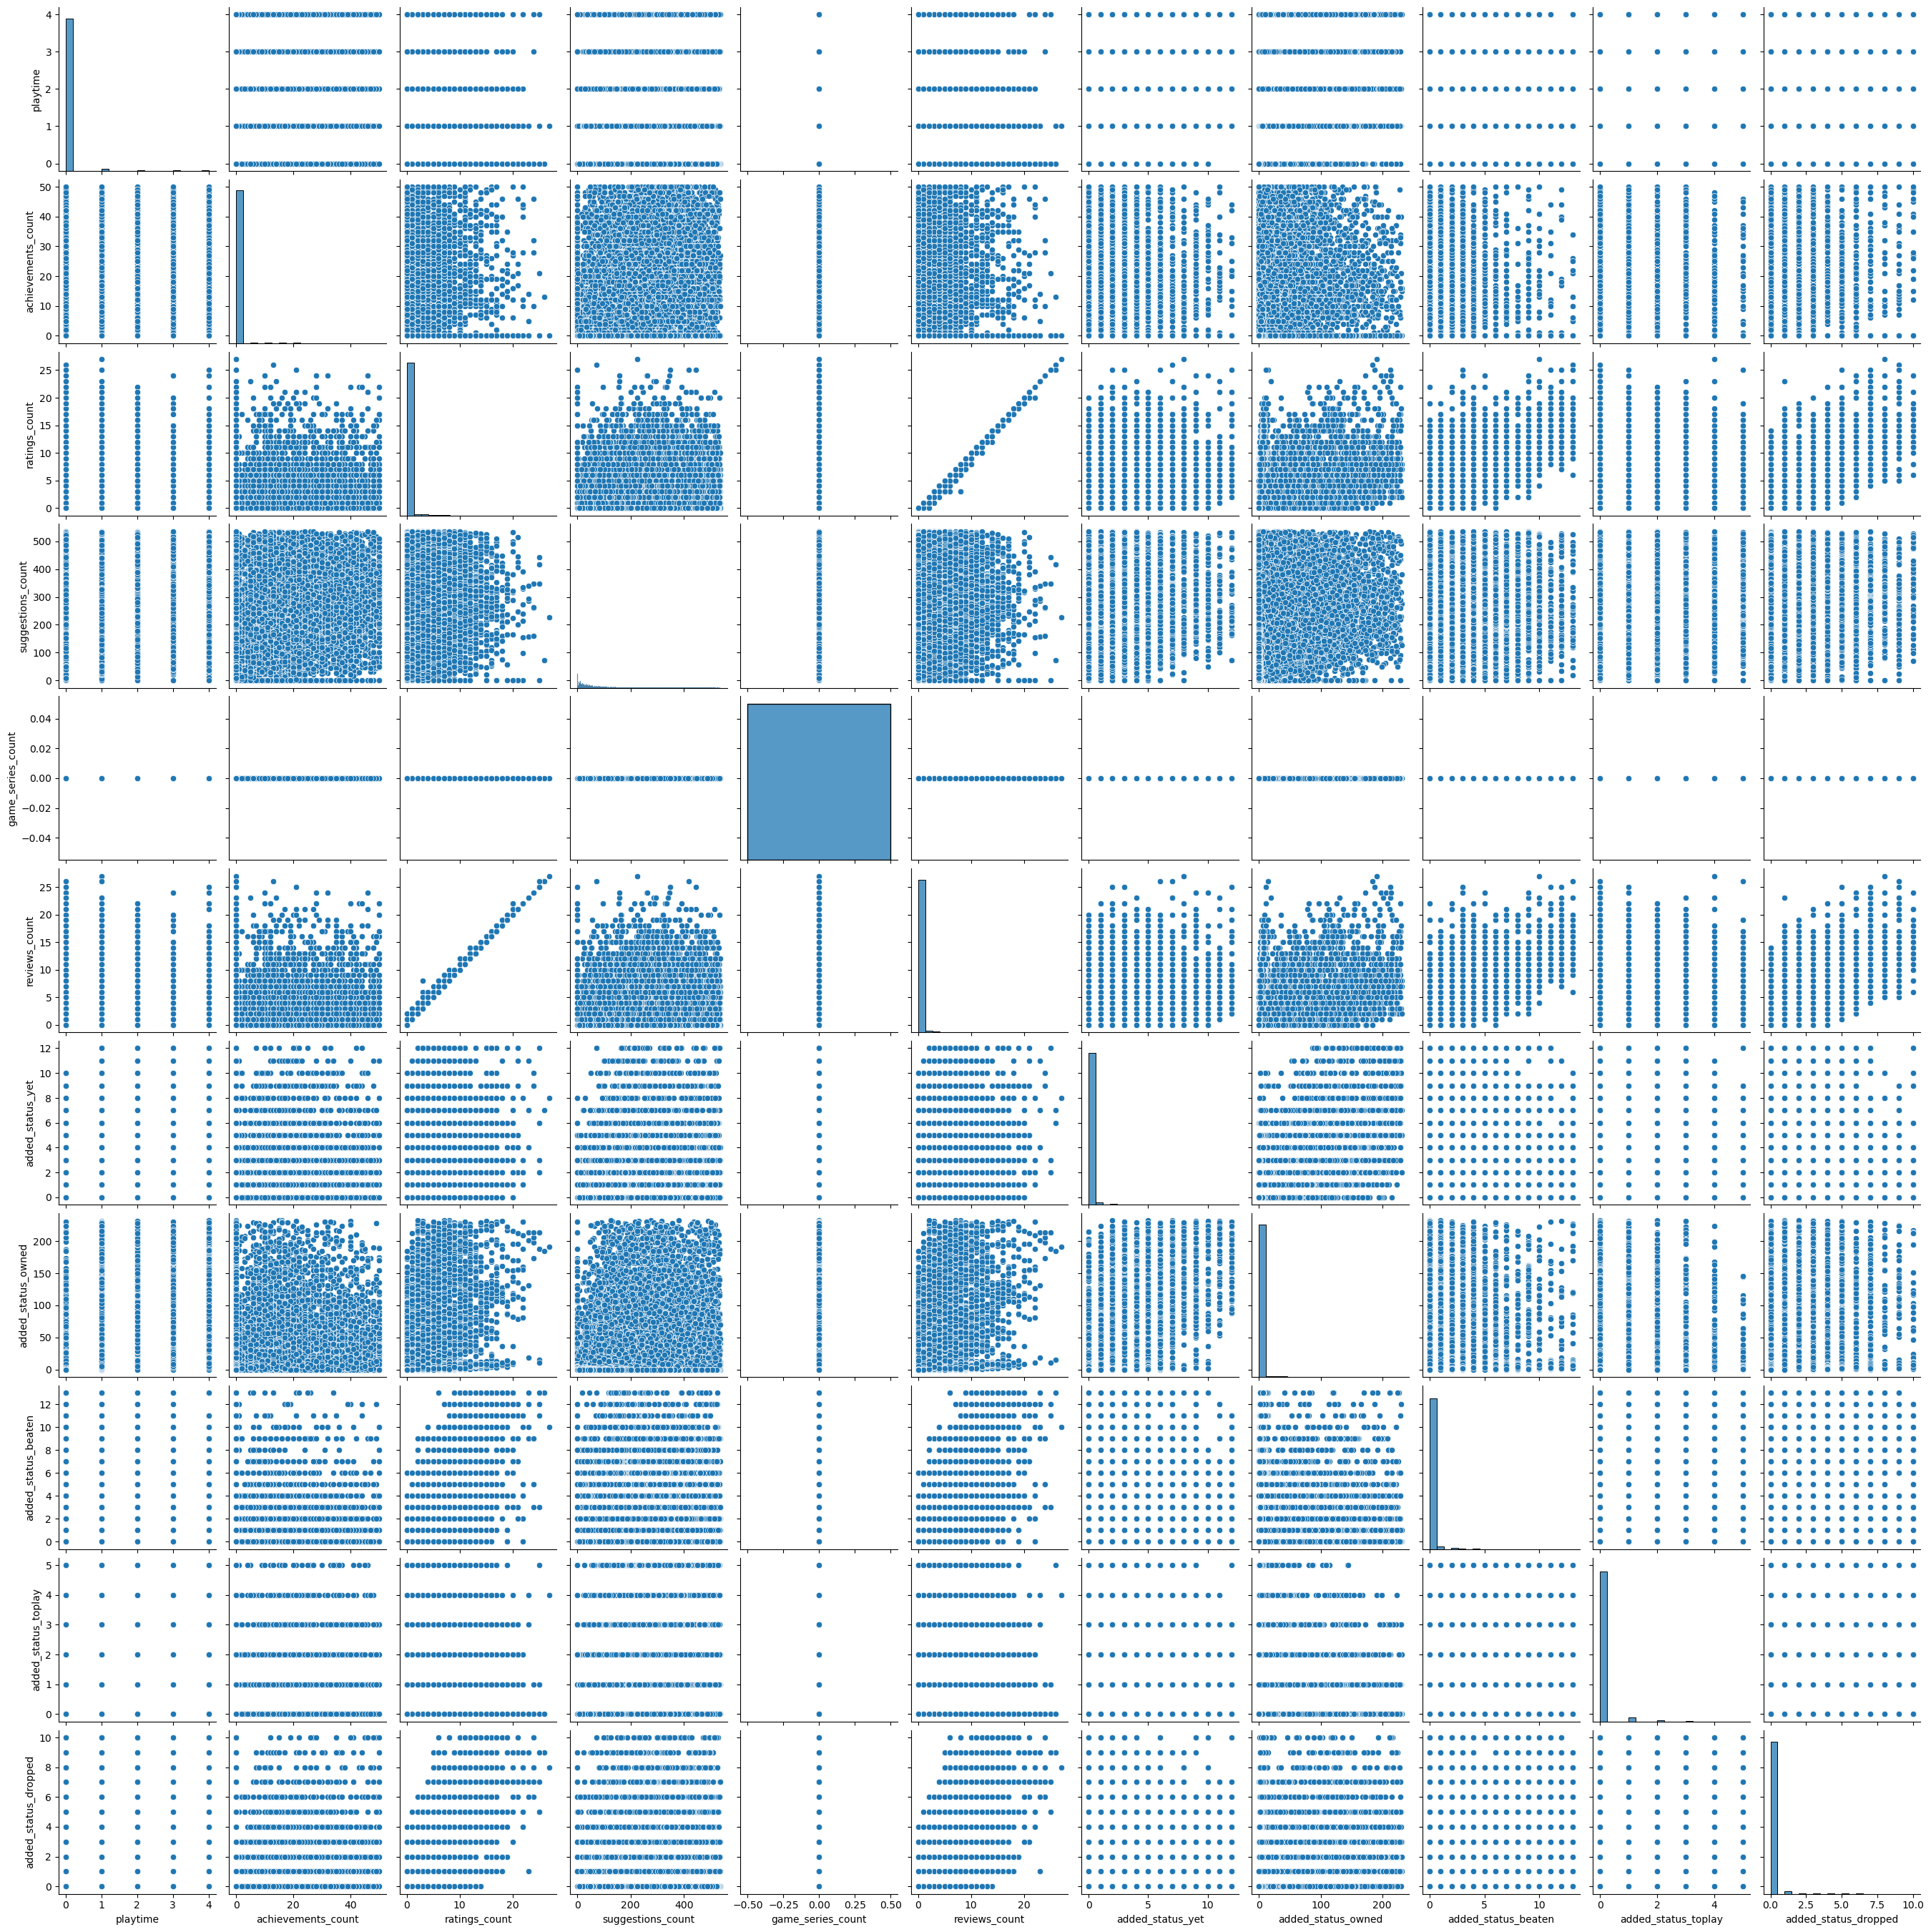

In [254]:
sns.pairplot(df[num_cols])

In [255]:
df.corr()

,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,Android,Linux,PC,Web,iOS,macOS,Other_platforms,Action,Adventure,Casual,Indie,Platformer,Puzzle,RPG,Shooter,Simulation,Strategy,Other_genres
rating,1.000000,0.854825,0.170176,0.172112,0.783162,0.144441,NaN,0.783395,0.426603,0.362605,0.663223,0.291717,0.632237,0.004344,0.004674,0.010250,-0.039585,-0.010016,0.007885,0.176843,0.026365,0.016682,0.023468,0.056678,-0.013308,-0.014315,0.015041,0.000796,0.006432,0.021410,0.023580
rating_top,0.854825,1.000000,0.185794,0.190022,0.780499,0.160936,NaN,0.781954,0.447366,0.374274,0.666827,0.317118,0.629667,0.005574,0.004734,0.011391,-0.044573,-0.010207,0.009233,0.196094,0.027636,0.019873,0.029257,0.066030,-0.015814,-0.016739,0.019561,-0.001117,0.007502,0.022530,0.026909
playtime,0.170176,0.185794,1.000000,0.447027,0.325618,0.257289,NaN,0.325384,0.417563,0.590014,0.172597,0.114392,0.217756,-0.010891,0.060604,0.111677,-0.076204,-0.026507,0.081268,0.042560,0.074656,0.093080,0.186044,0.392898,-0.043020,-0.035723,0.055162,-0.030027,0.054713,0.074937,-0.008603
achievements_count,0.172112,0.190022,0.447027,1.000000,0.299521,0.212779,NaN,0.299101,0.305036,0.392602,0.152799,0.098150,0.226374,-0.006136,0.038655,0.063169,-0.064520,-0.019568,0.057735,0.155588,0.062408,0.058557,0.145768,0.302230,-0.034045,-0.027007,0.038612,-0.019000,0.032420,0.051717,0.011358
ratings_count,0.783162,0.780499,0.325618,0.299521,1.000000,0.265511,NaN,0.997693,0.583423,0.572751,0.773271,0.398248,0.786455,0.010912,0.008775,0.028617,-0.081622,-0.010560,0.018674,0.275163,0.047246,0.042766,0.072395,0.146261,-0.035905,-0.028975,0.052891,-0.010936,0.020580,0.044999,0.040877
suggestions_count,0.144441,0.160936,0.257289,0.212779,0.265511,1.000000,NaN,0.266011,0.225288,0.242731,0.222894,0.299110,0.219366,0.071520,-0.001770,0.119827,-0.293656,0.089982,0.026391,0.193409,0.134970,0.172848,0.184715,0.349678,-0.104121,-0.065388,0.161032,-0.030634,0.113614,0.143152,0.108389
game_series_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviews_count,0.783395,0.781954,0.325384,0.299101,0.997693,0.266011,NaN,1.000000,0.583227,0.570287,0.775229,0.400870,0.787705,0.011399,0.008661,0.028220,-0.082034,-0.010222,0.018713,0.276878,0.047345,0.043021,0.072312,0.146694,-0.035933,-0.028970,0.053219,-0.011176,0.020614,0.045091,0.041078
added_status_yet,0.426603,0.447366,0.417563,0.305036,0.583423,0.225288,NaN,0.583227,1.000000,0.704993,0.390472,0.275428,0.445916,-0.002481,0.037487,0.058340,-0.065786,-0.017025,0.055631,0.144906,0.049297,0.063718,0.092376,0.212353,-0.031775,-0.026425,0.049721,-0.017391,0.020618,0.047365,0.000079
added_status_owned,0.362605,0.374274,0.590014,0.392602,0.572751,0.242731,NaN,0.570287,0.704993,1.000000,0.296911,0.138570,0.422356,-0.008776,0.044134,0.088976,-0.072614,-0.025031,0.062819,0.079215,0.068026,0.070002,0.154947,0.306518,-0.039488,-0.032048,0.039024,-0.024019,0.039309,0.066275,0.006507


# Model

In [256]:
X = df.drop(columns=['rating'])
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
y = df['rating']

## Continuous Model

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [258]:
getScores(X,y)

{'LinearRegression': 0.7667045618748776,
 'Lars': 0.6705929458458946,
 'Ridge': 0.7667046861410374,
 'Lasso': -0.0007869374820551611,
 'ElasticNet': -0.0007869374820551611,
 'BayesianRidge': 0.7667048033986608}

In [259]:
getScores(X,y,True)

Best parameters for Ridge: {'alpha': 50}


C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:909: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.281e+03, tolerance: 2.873e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fa

Best parameters for Lasso: {'alpha': 0}


C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.956e+03, tolerance: 2.873e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Best parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.0}


{'LinearRegression': 0.7667045618748776,
 'Lars': 0.6705929458458946,
 'Ridge': 0.7667076146981298,
 'Lasso': 0.766705505888789,
 'ElasticNet': 0.696005172617203,
 'BayesianRidge': 0.7667048033986608}

## Discrete Model

In [260]:
y = y.round()
y = y.astype('object')
y = pd.DataFrame(y, columns=['rating'])

In [261]:
y.value_counts()

rating
0.0       454395
4.0         1207
3.0          829
2.0          348
5.0           41
1.0           33
Name: count, dtype: int64

In [262]:
from sklearn.utils import resample
data = pd.concat([X, y], axis=1)
majority_class = data[data['rating'] == 0]
minority_classes = data[data['rating'] != 0]
majority_class_downsampled = resample(majority_class, 
                                      replace=False,
                                      n_samples=len(minority_classes),
                                      random_state=42) 

data_balanced = pd.concat([majority_class_downsampled, minority_classes])

X_balanced = data_balanced.drop(columns=['rating'])
y_balanced = data_balanced['rating']

In [263]:
param_grid = {
    'n_estimators': [10, 20, 30, 40,  50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc_ovo')

In [264]:
y_balanced = y_balanced.astype(int)

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [266]:
y_train

388455    0
168528    4
62245     4
55022     0
83716     0
         ..
433349    3
370287    0
114240    2
229152    4
309184    0
Name: rating, Length: 3441, dtype: int32

In [267]:
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [268]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(y_pred)

[0 4 0 ... 0 4 3]


In [269]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8610169491525423


In [270]:
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Confusion Matrix:
[[756   0   0   0   2   0]
 [  0   0  14   0   0   0]
 [  0   0  62  42   1   0]
 [  0   0  14 171  60   0]
 [  0   0   0  56 281   0]
 [  0   0   0   0  16   0]]


In [271]:
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       758
           1       0.00      0.00      0.00        14
           2       0.69      0.59      0.64       105
           3       0.64      0.70      0.67       245
           4       0.78      0.83      0.81       337
           5       0.00      0.00      0.00        16

    accuracy                           0.86      1475
   macro avg       0.52      0.52      0.52      1475
weighted avg       0.85      0.86      0.85      1475



C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [272]:
roc_auc_score(y_true=y_test, y_score=best_model.predict_proba(X_test), multi_class='ovr')

0.9681064456039321